# Part I: Brain states via Adaptive Exponential mean-field model

## EITN Fall School, 19-28 November 2025, Marseille

## TVB-AdEx hands on session, 24 November 2025

###### *This code was prepared and put in tutorial form by Emre Baspinar.* 

###### *It uses some dependencies prepared by Matteo di Volo and Yann Zerlaut.*

###### *Coordinated by Alain Destexhe*

Contact: emre.baspinar@inria.fr

## Context

Dynamics of a neuronal population can be modeled by using mainly networks and mean-field systems. In a neuronal network, each neuron is represented in terms of a set of differential equations. Therefore, the network of a neuronal population is high dimensional, with a dimension of order of 10000
. The mean-field system of a network provides the approximation of the averaged dynamics of the corresponding network of the neuronal population. The approximation captures a large variety of the dynamics generated by the network, with less detail. The advantage is that the mean-field approximation is low dimensional, with a dimension of order 1. Therefore, easier to analyze, modify and adapt to the problem under consideration.

In this tutorial, we will simulate the mean-field approximation of the Adaptive Exponential network [2]. Adaptive Exponential (AdEx) mean-field approximates the averaged firing rates of a pair of excitatory-inhibitory neuronal populations with spike frequency adaptation. The excitatory and inhibitory populations are composed of Regularly Spiking (RS) and Fast Spiking (FS) neurons, respectively. The transfer functions of RS and FS cells were obtained by fitting a semi-analytical function to in vitro measurements, as well as to the RS and FS responses of an AdEx network bombarded by spikes generated from a Poisson distribution. The RS neurons display spike-frequency adaptation as observed in the pyramidal neurons, and the FS neurons has no adaptation as observed in the interneurons. These points provide a biophysical ground for the AdEx mean-field framework.

Originality of the AdEx mean-field is that it can generate different brain states: asynchronous irregular (AI) and up-down states. The first one is the brain state observed during awakeness. During this state, spontaneous activity (no stimulus) is chaotic and irregular. There is very little or no synchronization in the population activity. The second one is the state observed during sleep or anesthesia. During this state, a strong synchronization is observed. This synchronization manifests itself in terms of up states, during which almost all the neurons fire and an increased firing rate is observed; and down states, in which the majority of the neurons are silent and they do not fire. 

## Objective

The objective of this tutorial is to build a simulation setup which we can produce the AI and up-down states by using the AdEx mean-field framework. More precisely, we aim to

- generate the AI state
- construct different stimulation types
- stimulate the model in AI state (AI response)
- generate the up-down state
- stimulate the model in up-down state (up-down state response)

## Initialization

The first thing to do is to import the modules which we will need for the simulations.

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import random
import math
from theoretical_tools import get_fluct_regime_varsup, pseq_params,TF_my_templateup
from scipy.special import erf
from DiffOperator import DifferentialOperator
from SDEIntegrator import TimeStepping
from NeuronConnectivity import ReformatSynParameters, LoadTransferFunctions

## AdEx mean-field model

The model equations are as follows:
\begin{equation}
\begin{split}
T \,\partial_t v_\alpha & = (F_\alpha -v_\alpha) + \frac{1}{2} C_{\xi\eta}\partial_{\xi\eta}F_\alpha+\xi_\alpha\\
T\,\partial_t C_{\alpha\beta} & =\delta_{\alpha\beta}A_{\alpha\alpha} + (F_\alpha-v_\alpha)(F_\beta-v_\beta) + C_{\beta\xi}\partial_\xi F_\alpha + C_{\alpha\xi}\partial_\xi F_\eta-2 C_{\alpha\beta}\\
\partial_t W & = -\frac{W}{\tau_w} + b v_e + a(\mu_V(v_e, v_i, W) - E_L),\hspace{12cm}(1)
\end{split}
\end{equation}
where $\alpha,\,\beta$ denote the populations. Each one of them can be either $e$ (excitatory) or $i$ (inhibitory). Here $v_\alpha$ is the averaged firing rate of the population $\alpha$ and $F_\alpha$ denotes the neuronal transfer function of the population $\alpha$. Finally, $C_{\alpha\beta}$ denotes the correlation between the firing rates of the populations $\alpha$ and $\beta$, and $W$ represents the slow spike frequency adaptation of the excitatory population. Here $T$ is the time scale of $v$ and $C$ variables, $\tau_e$ is the timescale parameter for the slow adaptation $W$. Finally, $\xi_\alpha$ is a Gaussian white noise generated independently at each time instant for each population $\alpha$ It is provided as an additional noise in the base drive, which is explained brelow. The other terms have rather technical importance, we refer to [1, 2, 3, 6] for their explanations.

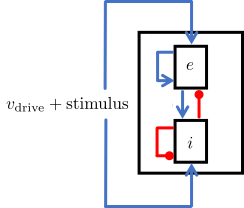


<b>Fig. 1: Neuronal population model. A population pool is composed of one excitatory ($e$) and one inhibitory ($i$) neuronal population. Here $v_{\text{drive}}$ represents the base-drive potential keeping the model in the asynchronous irregular (awake) state. </b>

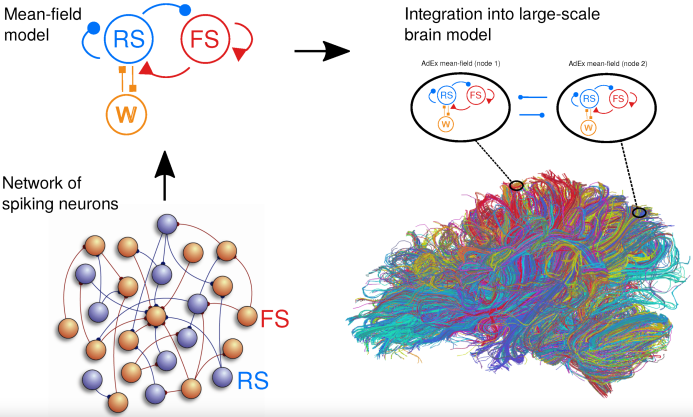

<b>Fig. 2: Figure adapted from [4, 5]: From AdEx network towards TVB model with nodes based on AdEx mean-field systems. Each node is modeled in terms of excitatory (regularly spiking, RS) and inhibitory (fast spiking, FS) neuronal populations, where RS population dynamics are modulated by spike-frequency adaptation. </b>

## Asynchronous irregular state: spontaneous activity
We will generate and plot the AI state first in a deterministic framework with no stimulation. This is the spontaneous activity in the awake state. We first determine the simulation parameters.

In [ ]:
tFinal = 5      # the final time instant of the simulation
tStep = 5e-4    # time step
T = 50e-3       # time scale of the firing rates and the covariance terms

We provide the base drive as a constant input equal to 2.5 Hz. It is important to fix the base drive to a sufficiently large value to keep the AdEx model in the AI state. We consider the deterministic case for the moment, so the base drive has no noise component.

In [ ]:
vDrive = 5                  # base drive to keep the model in the preferred state: = 2.5 for AI, = 0.315 for up-down state
noiseAmplitude = 0          # deterministic system, no noise for the moment...

We choose the initial conditions such that the model converges to an AI state.

In [ ]:
# Initial conditions
ve0 = 1.      # excitatory firing rate
vi0 = 30.     # inhibitory firing rate
Cee = 0.5     # activity correlations between excitatory neurons
Cei = 0.5     # activity correlations between excitatory and inhibitory neurons
Cii = 0.5     # activity correlations between inhibitory neurons
We  = 1.e-10  # spike frequency adaption for the excitatory (RS) cells
Wi  = 0.      # spike frequency adaption for the inhibitory (FS) cells...It will remain 0 since the FS cells have no adaptation.

initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

We are interested in the spontaneous activity, i.e., the activity in the absence of any external stimulus. Therefore, we fix the stimulus to 0.

In [ ]:
t = np.arange(int(tFinal/tStep))*tStep   # time vector 
stimulus = np.zeros(np.shape(t)[0])      # define stimulus: no stimulus for spontaneous activity

We are ready for the time integration. TimeStepping function uses a forward Euler scheme for the time integration of the AdEx mean-fied system. The inputs 'RS-cell_UD', 'FS-cell' import the cell parameters of the corresponding transfer functions, and 'CONFIG1' imports the parameters regarding neuronal connectivity and synaptic properties. Here "state" stores all the dynamic variables described by the AdEx mean-field model. The time integration might take some time, depending on tFinal and tStep.

In [ ]:
state = TimeStepping('RS-cell', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

We can plot the corresponding results once the simulation is over.

In [ ]:
t = np.arange(int(tFinal/tStep))*tStep                   # time axis for the firing rate plots
plt.plot(t,state[0,:], label = "exc.")                   # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")            # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.xlabel("Time, s")
plt.ylabel("Firing rate, Hz")
plt.legend(loc="upper right")
plt.show()

We have used a deterministic framework up to now, with no noise in the system. However, the noise is inevitable to take into account the distortion effects due to whatsover perturbative mechanisms. We model these distortion effects as an Ornstein-Uhlenbeck process given by

$$
d\xi(t) = -\frac{\xi(t)}{\tau_{\text{OU}}}dt + dW_t,
$$
where $\tau_{\text{OU}}$ is the time scale of the process and $dW_t$ is a Wiener process. We use a typical Euler-Maruyama scheme for the time integration of $\xi(t)$. We scale $\xi(t)$ with $\sigma$ and add it to our base drive, i.e.,

$$
\tilde{v}_\text{drive} = v_\text{drive} + \sigma\, \xi(t).
$$
Note that here $\sigma$ is actually the noise amplitude.

Let us have a look the effect of noise on the AI output.

In [ ]:
noiseAmplitude = 0.5          # noise amplitude of the Ornstein-Uhlenbeck term fed into vDrive

We should reset the initial conditions. Then we run the simulation, this time with a noisy base drive, and plot the results.

In [ ]:
initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]
state = TimeStepping('RS-cell', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

t = np.arange(int(tFinal/tStep))*tStep   # time axis for the firing rate plots
plt.plot(t,state[0,:], label = "exc.")                   # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")                   # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.xlabel("Time, s")
plt.ylabel("Firing rate, Hz")
plt.legend(loc="upper right")
plt.show()

## Asynchronous irregular state: stimulated activity
We consider the responses of the AdEx mean-field model to different types of stimulus. We will be using the same paramters. The only difference is that our stimulus will be a function of time. We will use three types of stimuli.

In [ ]:
# Stimuli
def heaviside(x):
    return 0.5*(1+np.sign(x))


def doubleGaussian(t, t0, T1, T2, amplitude):   # T1 and T2 are the scales of the Gaussian components
    
    return amplitude*(\
                      np.exp(-(t-t0)**2/2./T1**2)*heaviside(-(t-t0))+\
                      np.exp(-(t-t0)**2/2./T2**2)*heaviside(t-t0))

def sinewave(t, t0, frequency, amplitude, phase=0):   # t0 is the time instant at which the stimuli is applied
    return amplitude*(1-np.cos(2.*np.pi*frequency*(t-t0)+phase))*heaviside(t-t0)/2    

Let us plot the stimuli.

In [ ]:
amplitude = 5
t0 = 2.
T1 = 0.01
T2 = 0.2
frequency = 5

stimulus1 = doubleGaussian(t, t0, T1, T2, amplitude)
stimulus2 = sinewave(t, t0, frequency, amplitude, phase=0)

figure, axis = plt.subplots(1, 2, figsize=(10, 2)) 
  
# For Double Gaussian 
axis[0].plot(t, stimulus1, 'black', alpha=0.3) 
axis[0].set_title("Double Gaussian")
axis[0].set_xlabel('Time, s')
axis[0].set_ylabel('Rate, Hz')
  
# For sine wave 
axis[1].plot(t, stimulus2, 'black', alpha=0.3) 
axis[1].set_title("Sine wave")
axis[1].set_xlabel('Time, s')
axis[1].set_ylabel('Rate, Hz')

plt.show() 


We reset the initial conditions and stimulate the AdEx model with the double Gaussian.

In [ ]:
initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

stimulus = stimulus1
state = TimeStepping('RS-cell', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

t = np.arange(int(tFinal/tStep))*tStep                   # time axis for the firing rate plots
plt.plot(t,state[0,:], label = "exc.")                   # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")            # plot the inhibitory population firing rate
plt.plot(t,stimulus1, 'black',alpha=0.3, label = "stim.")                 # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.xlabel("Time, s")
plt.ylabel("Rate, Hz")
plt.legend(loc = "upper right")
plt.show()

...and now with the sine wave.

In [ ]:
initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

stimulus = stimulus2
state = TimeStepping('RS-cell', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

t = np.arange(int(tFinal/tStep))*tStep                   # time axis for the firing rate plots
plt.plot(t,state[0,:], label = "exc.")                   # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")            # plot the inhibitory population firing rate
plt.plot(t,stimulus2, 'black', alpha=0.3, label = "stim.")                # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.xlabel("Time, s")
plt.ylabel("Rate, Hz")
plt.legend(loc = "upper right")
plt.show()

## Up-down state: spontaneous activity

We increase the spike frequency adaptation so that the population activity is modulated towards synchronized up states separated by synchronized down states. We first change the base drive. We choose it smaller to keep the model out of the AI state. We first consider the deterministic case, with no noise.

In [ ]:
vDrive = 0.315      # base drive to keep the model in the preferred state: = 2.5 for AI, = 0.315 for up-down state
noiseAmplitude = 0  # deterministic case, no noise
# noiseAmplitude = 1e-1*5 # noise amplitude of the Ornstein-Uhlenbeck term fed into vDrive

We set the initial conditions in accordance with the up-down state. A good set of initial conditions is that all state variables are 0.

In [ ]:
# Initial conditions
ve0 = 0     # excitatory firing rate
vi0 = 0     # inhibitory firing rate
Cee = 0     # activity correlations between excitatory neurons
Cei = 0     # activity correlations between excitatory and inhibitory neurons
Cii = 0     # activity correlations between inhibitory neurons
We  = 0     # spike frequency adaption for the excitatory (RS) cells
Wi  = 0     # spike frequency adaption for the inhibitory (FS) cells...It will remain 0 since the FS cells have no adaptation.

initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

We consider the spontaneous activity, therefore we feed no stimulus as in the previous case of AI state.

In [ ]:
stimulus = np.zeros(np.shape(t)[0])      # define stimulus: no stimulus for spontaneous activity
state = TimeStepping('RS-cell_UD', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

plt.plot(t,state[0,:], label = "exc.")                   # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")            # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.ylim(-0.1, 20)
plt.xlabel("Time, s")
plt.ylabel("Rate, Hz")
plt.legend(loc = "upper right")

plt.show()

In deterministic setting, we do not have the up-down states since there is no triggering component for the model to jump back and forth between these two states. Noise in this case plays a crucial role. It does not model only the distortion effects on the neuronal dynamics, but also, it triggers the model to oscillate between the up and down states. Let us add the noise to generate the up-down states.

In [ ]:
noiseAmplitude = 0.5 # deterministic case, no noise

tFinal = 5      # the final time instant of the simulation
tStep = 5e-4    # time step
T = 50e-3       # time scale of the firing rates and the covariance terms
t = np.arange(int(tFinal/tStep))*tStep 

# Initial conditions
ve0 = 0     # excitatory firing rate
vi0 = 0     # inhibitory firing rate
Cee = 0     # activity correlations between excitatory neurons
Cei = 0     # activity correlations between excitatory and inhibitory neurons
Cii = 0     # activity correlations between inhibitory neurons
We  = 0     # spike frequency adaption for the excitatory (RS) cells
Wi  = 0     # spike frequency adaption for the inhibitory (FS) cells...It will remain 0 since the FS cells have no adaptation.

initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

stimulus = np.zeros(np.shape(t)[0])      # define stimulus: no stimulus for spontaneous activity
state = TimeStepping('RS-cell_UD', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

plt.plot(t,state[0,:], label = "exc.")                   # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")            # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
# plt.ylim(0, 20)
plt.xlabel("Time, s")
plt.ylabel("Rate, Hz")
plt.legend(loc = "upper right")

plt.show()

Let us plot the firing rates separately.

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(10, 2)) 
  
# For RS population 
axis[0].plot(t, state[0,:])
# plt.ylim(0,200)
axis[0].set_title("exc. sync. activity")
axis[0].set_xlabel('Time, s')
axis[0].set_ylabel('Rate, Hz')
  
# For FS population 
axis[1].plot(t, state[1,:], 'red')
# plt.ylim(0,200)
axis[1].set_title("inh. sync. activity")
axis[1].set_xlabel('Time, s')
axis[1].set_ylabel('Rate, Hz')

plt.show() 

## Up-down state: stimulated activity

Finally, we consider the stimulated activity in the up-down state. We will use the same stimuli which we used to stimulate the AI state.

In [ ]:
amplitude = 5
t0 = 2.
T1 = 0.01
T2 = 0.2
frequency = 1

stimulus1 = doubleGaussian(t, t0, T1, T2, amplitude)
stimulus2 = sinewave(t, t0, frequency, amplitude, phase=0)

We will first apply the double Gaussian.

In [ ]:
initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

stimulus = stimulus1
state = TimeStepping('RS-cell', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

t = np.arange(int(tFinal/tStep))*tStep                        # time axis for the firing rate plots
plt.plot(t,state[0,:], label = "exc.")                        # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")                 # plot the inhibitory population firing rate
plt.plot(t,stimulus1, 'black', alpha=0.3, label = "stim.")    # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.xlabel("Time, s")
plt.ylabel("Rate, Hz")
plt.legend(loc = "upper right")
plt.show()

...and now the sine wave.

In [ ]:
initConditions = [ve0, vi0, Cee, Cei, Cii, We, Wi]

stimulus = stimulus2
state = TimeStepping('RS-cell', 'FS-cell', 'CONFIG1', T, tStep, tFinal, stimulus, vDrive, noiseAmplitude, initConditions)

t = np.arange(int(tFinal/tStep))*tStep                           # time axis for the firing rate plots
plt.plot(t,state[0,:], label = "exc.")                           # plot the excitatory population firing rate
plt.plot(t,state[1,:], 'red', label = "inh.")                    # plot the inhibitory population firing rate
plt.plot(t,stimulus2, 'black', alpha=0.3, label = "stim.")       # plot the inhibitory population firing rate
plt.xlim(0.1, tFinal)
plt.xlabel("Time, s")
plt.ylabel("Rate, Hz")
plt.legend(loc = "upper right")
plt.show()

### References

[1]: Baspinar, E., Cecchini, G., DePass, M., Andujar, M., Pani, P., Ferraina, S., Moreno-Bote, R., Cos, I., Destexhe, A. (2023). A biologically plausible decision-making model based on interacting cortical columns. bioRxiv, 2023-02.

[2]: Brette, R., Gerstner, W. (2005), Adaptive exponential integrate-and-fire model as an effective description of neuronal activity, J. Neurophysiol., 94(5), 3637-3642.

[3]: Di Volo, M., Romagnoni, A., Capone, C., Destexhe, A. (2019). Biologically realistic mean-field models of conductance-based networks of spiking neurons with adaptation. Neural Computation, 31(4), 653-680.

[4]: Goldman, J. S., Kusch, L., Aquilue, D., Yalçınkaya, B. H., Depannemaecker, D., Ancourt, K., Nghiem, T. E., Jirsa, V., Destexhe, A. (2023). A comprehensive neural simulation of slow-wave sleep and highly responsive wakefulness dynamics. Frontiers in Computational Neuroscience, 16, 1058957.

[5]: Sacha, M., Goldman, J. S., Kusch, L., Destexhe, A. (2024). Asynchronous and slow-wave oscillatory states in connectome-based models of mouse, monkey and human cerebral cortex. Applied Sciences, 14(3), 1063.

[6]: Zerlaut, Y., Chemla, S., Chavane, F., & Destexhe, A. (2018). Modeling mesoscopic cortical dynamics using a mean-field model of conductance-based networks of adaptive exponential integrate-and-fire neurons. Journal of Computational Neuroscience, 44(1), 45-61.